##### https://www.kaggle.com/mingtang12/insurancepredict-decisiontr-randomf-logisticr-knn

## 1. 필요한 라이브러리 및 데이터 불러오기

In [19]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

df=pd.read_csv("C:/Users/USER/Desktop/reg2_final/health_insurance.csv")

## 2. 데이터 요약하기

In [ ]:
df.head() # 상위 5개 데이터 확인
df.info() # 데이터 정보
pd.isnull(df).sum() # 결측치 수
df.nunique() # unique한 관측 개수?

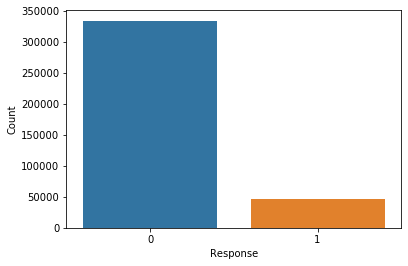

In [19]:
# Response(반응변수)
fig_dims = (5, 5)
fig, ax = plt.subplots()
sns.countplot('Response',
              data = df,
              order = df['Response'].value_counts().index,
              ax = ax)
ax.set(xlabel='Response', ylabel='Count')
plt.show()

Text(0.5, 1.0, 'Driving_License')

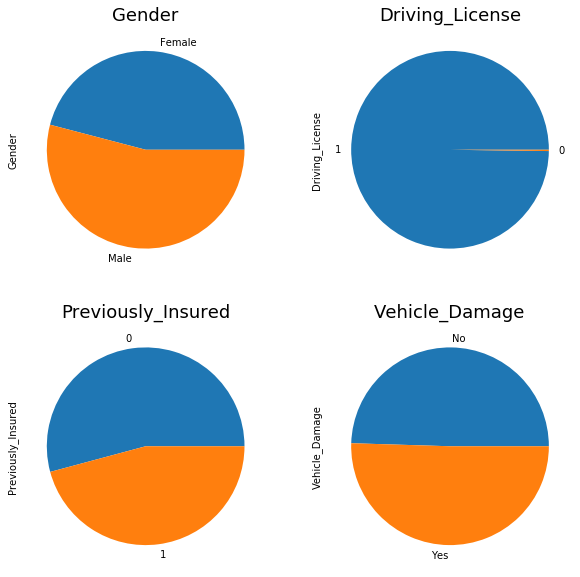

In [21]:
# Gender,Driving_License,Previously_Insured,Vehicle_Damage(범주형?)
fig, axarr = plt.subplots(2, 2, figsize=(10, 10))

df['Gender'].value_counts().sort_index().plot.pie(
    ax=axarr[0][0])
axarr[0][0].set_title("Gender", fontsize=18)
df['Previously_Insured'].value_counts().sort_index().plot.pie(
    ax=axarr[1][0])
axarr[1][0].set_title("Previously_Insured", fontsize=18)

df['Vehicle_Damage'].value_counts().sort_index().plot.pie(
    ax=axarr[1][1])
axarr[1][1].set_title("Vehicle_Damage", fontsize=18)

df['Driving_License'].value_counts().head().plot.pie(
    ax=axarr[0][1])
axarr[0][1].set_title("Driving_License", fontsize=18)

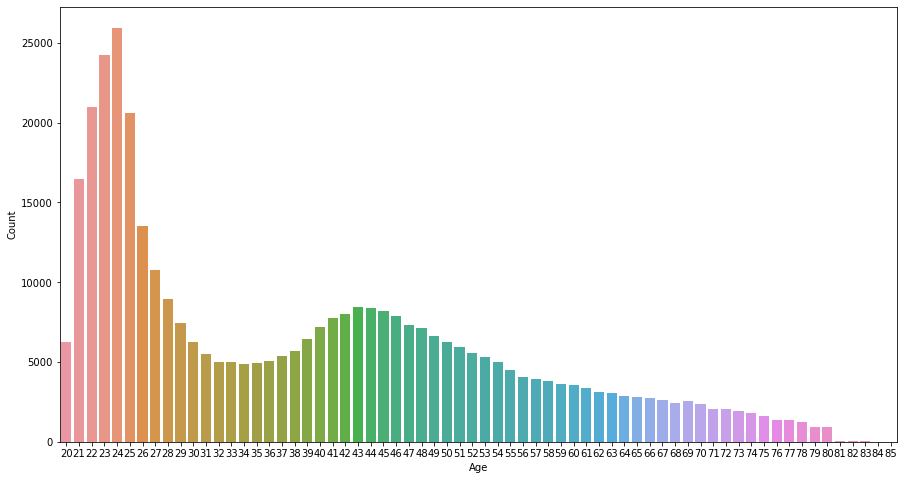

In [23]:
# Age
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot('Age',
              data = df,
              ax = ax)
ax.set(xlabel='Age', ylabel='Count')
plt.show()

In [20]:
# Encoding
df['Gender'].replace(to_replace={'Male':0,'Female':1},
             inplace=True)
df['Vehicle_Damage'].replace(to_replace={'No':0,'Yes':1},
             inplace=True)
df['Vehicle_Age'].replace(to_replace={'< 1 Year':0,'1-2 Year':1,'> 2 Years':2},
             inplace=True)

In [36]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
id                      381109 non-null int64
Gender                  381109 non-null int64
Age                     381109 non-null int64
Driving_License         381109 non-null int64
Region_Code             381109 non-null float64
Previously_Insured      381109 non-null int64
Vehicle_Age             381109 non-null int64
Vehicle_Damage          381109 non-null int64
Annual_Premium          381109 non-null float64
Policy_Sales_Channel    381109 non-null float64
Vintage                 381109 non-null int64
Response                381109 non-null int64
dtypes: float64(3), int64(9)
memory usage: 34.9 MB
None
   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1       0   44                1         28.0                   0   
1   2       0   76                1          3.0                   0   
2   3       0   47                1         28.0           

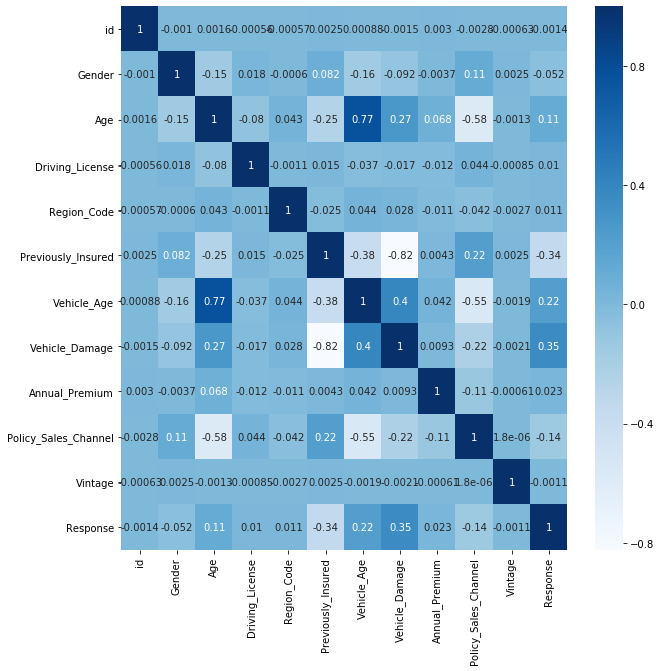

In [38]:
# Correlation Heatmap
plt.figure(figsize=(10,10))
cor=df.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

In [42]:
df.describe() 

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,0.459239,38.822584,0.997869,26.388807,0.458210,0.609616,0.504877,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,0.498336,15.511611,0.046110,13.229888,0.498251,0.567439,0.499977,17213.155057,54.203995,83.671304,0.327936
min,1.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,0.000000,25.000000,1.000000,15.000000,0.000000,0.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,0.000000,36.000000,1.000000,28.000000,0.000000,1.000000,1.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,1.000000,49.000000,1.000000,35.000000,1.000000,1.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,1.000000,85.000000,1.000000,52.000000,1.000000,2.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


## 3. 데이터 나누기

In [21]:
# id는 설명변수로 부적절하므로 제외
df=df.drop(columns=['id']) 

In [22]:
y=df.Response # 반응변수
X=df.drop(columns=['Response']) # 설명변수

In [23]:
# split into 70% train set and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 4. 로지스틱 모형 적합

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
print(classification_report(y_test, lr_predict))
lr_accuracy = accuracy_score(y_test, lr_predict)
print("Accuracy of Logistic Regression" + ' : ' + str(lr_accuracy))

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100195
           1       0.00      0.00      0.00     14138

    accuracy                           0.88    114333
   macro avg       0.44      0.50      0.47    114333
weighted avg       0.77      0.88      0.82    114333

Accuracy of Logistic Regression : 0.8763436628095126


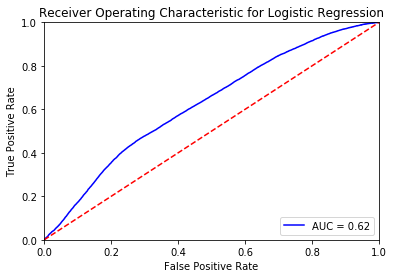

In [48]:
# Plot ROC_AUC for logistic regression
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5. 로지스틱 모형 해석

In [50]:
import statsmodels.api as sm
logit = sm.Logit(y_train,X_train) #로지스틱 회귀분석 시행
result = logit.fit()
print(result.summary2()) # 결정계수가 너무 작은데?
print(np.exp(result.params)) # 오즈비
print(result.predict(X_train))

Optimization terminated successfully.
         Current function value: 0.277680
         Iterations 11
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.252      
Dependent Variable:  Response          AIC:               148176.7234
Date:                2020-11-25 17:25  BIC:               148281.6651
No. Observations:    266776            Log-Likelihood:    -74078.    
Df Model:            9                 LL-Null:           -98995.    
Df Residuals:        266766            LLR p-value:       0.0000     
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      11.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Gender               -0.1207   0.0132  -9.1218 0.0000 -0.1467 -0.0948
Age            